# Load Data

In [4]:
#!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.6 ms (started: 2021-03-07 16:29:24 +00:00)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
# load the dataset
column_names = ['age',
                'workclass',
                'fnlwgt',
                'education',
                'education-num',
                'marital-status',
                'occupation',
                'relationship',
                'race',
                'sex',
                'capital-gain',
                'capital-loss',
                'hours-per-week',
                'native-country',
                'high_income'
                ]

# df_purchase = pd.read_csv('purchase data.csv')

from google.colab import drive
drive.mount('/content/drive')

# Load the data, contained in the segmentation data csv file.
GD_PATH = '/content/drive/MyDrive/扬FAANG起航/单项准备/xgboost/'
#df_purchase = pd.read_csv(GD_PATH+'purchase data.csv', index_col = 0)

income = pd.read_csv(GD_PATH+"adult.data.csv", sep=",", names = column_names).head(1000)
income.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1000 non-null   int64 
 1   workclass       1000 non-null   object
 2   fnlwgt          1000 non-null   int64 
 3   education       1000 non-null   object
 4   education-num   1000 non-null   int64 
 5   marital-status  1000 non-null   object
 6   occupation      1000 non-null   object
 7   relationship    1000 non-null   object
 8   race            1000 non-null   object
 9   sex             1000 non-null   object
 10  capital-gain    1000 non-null   int64 
 11  capital-loss    1000 non-null   int64 
 12  hours-per-week  1000 non-null   int64 
 13  native-country  1000 non-null   object
 14  high_income     1000 non-null   object
dtypes: int64(6), object(9)
memory usage: 117.3+ KB
time: 25.3 s (started: 2021-03-07 16:29:24 +00:00)


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [7]:
income

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,56,Private,112840,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,>50K
996,45,Private,89325,Masters,14,Divorced,Prof-specialty,Not-in-family,White,Male,0,0,45,United-States,<=50K
997,48,Federal-gov,33109,Bachelors,13,Divorced,Exec-managerial,Unmarried,White,Male,0,0,58,United-States,>50K
998,40,Private,82465,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,2580,0,40,United-States,<=50K


time: 55.5 ms (started: 2021-03-07 16:30:22 +00:00)


time: 546 ms (started: 2021-03-07 16:30:23 +00:00)


In [9]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]
# converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()
        if self.new_features:
            # Treat ? workclass as unknown
            df['workclass']= df['workclass'].replace('?','Unknown') 
            # Two many category level, convert just US and Non-US
            df.loc[df['native-country']!=' United-States','native-country'] = 'non_usa'
            df.loc[df['native-country']==' United-States','native-country'] = 'usa'
        # convert columns to categorical
        for name in df.columns.to_list():
            col = pd.Categorical(df[name])
            df[name] = col.codes
        # returns numpy array
        return df

time: 27 ms (started: 2021-03-07 16:30:24 +00:00)


In [11]:
# Create the X feature matrix and the y target vector
X = income.drop(labels="high_income", axis=1)
y = income["high_income"]
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
col = pd.Categorical(y)
y = pd.Series(col.codes)
# global variables
seed = 108

In [12]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("int64").columns.to_list()

# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('cat_transformer', CategoricalTransformer())
]

# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('std_scaler', StandardScaler()),
]

# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

In [13]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)

In [14]:
# we pass the preprocessing pipeline as a step to the full pipeline
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', DecisionTreeClassifier(random_state=seed))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)

In [15]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "model": [DecisionTreeClassifier(random_state=seed)],
    "model__criterion": ["gini","entropy"],
    "model__splitter": ["best","random"],
    "model__max_leaf_nodes": [16, 64, 128, 256],
    "model__max_depth": np.linspace(1, 32, 32)
}

scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}

# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
n_iter=50
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC"
)

# fit grid search
best_model = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [16]:
# final Decision Tree model
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8675
Test Accuraccy:  0.795

Confusion Matrix:
[[137  17]
 [ 24  22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       154
           1       0.56      0.48      0.52        46

    accuracy                           0.80       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.78      0.80      0.79       200



In [17]:
# we pass the preprocessing pipeline as a step to the full pipeline
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', BaggingClassifier(
        DecisionTreeClassifier(max_features="auto", splitter="random", max_leaf_nodes=128, random_state=seed),
        random_state=seed
    ))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)
# Create the grid search parameter grid
param_grid = {
    "model": [BaggingClassifier(
        DecisionTreeClassifier(max_features="auto", splitter="random", max_leaf_nodes=128, random_state=seed),
        random_state=seed
    )],
    "model__n_estimators":  np.arange(100, 1000, 100),
    "model__max_samples":[0.8, 1.0], 
    "model__max_features": [0.8, 1.0],
    "model__bootstrap": [True],
    "model__oob_score": [True],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
n_iter=25
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC"
)
                                      
# fit grid search
best_bag = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [18]:
print(f'Best score: {best_bag.best_score_}')
print(f'Best model: {best_bag.best_params_}')

Best score: 0.8751615067989029
Best model: {'model__oob_score': True, 'model__n_estimators': 300, 'model__max_samples': 1.0, 'model__max_features': 1.0, 'model__bootstrap': True, 'model': BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=128,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                  

In [21]:
pred_test = best_bag.predict(X_test)
pred_train = best_bag.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
#print("Out-of-Bag Accuracy: ", best_bag.best_params_['model'].oob_score_)
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.97375
Test Accuraccy:  0.835

Confusion Matrix:
[[150   4]
 [ 29  17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       154
           1       0.81      0.37      0.51        46

    accuracy                           0.83       200
   macro avg       0.82      0.67      0.70       200
weighted avg       0.83      0.83      0.81       200



In [20]:
# we pass the preprocessing pipeline as a step to the full pipeline
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', RandomForestClassifier(random_state=seed))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "model": [RandomForestClassifier(random_state=seed)],
    "model__max_depth": np.linspace(1, 32, 32),
    "model__n_estimators": np.arange(100, 1000, 100),
    "model__criterion": ["gini","entropy"],
    "model__max_leaf_nodes": [16, 64, 128, 256],
    "model__oob_score": [True],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
n_iter=50
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC"
)
# fit grid search
best_rf = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KeyboardInterrupt: ignored

In [ ]:
print(f'Best score: {best_rf.best_score_}')
print(f'Best model: {best_rf.best_params_}')

In [ ]:
pred_test = best_rf.predict(X_test)
pred_train = best_rf.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print("Out-of-Bag Accuracy: ", best_rf.best_params_['model'].oob_score_)
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

In [ ]:
# lets get the random forest model configuration and feature names
rf_model = best_rf.best_params_['model']
features = np.array(X_train.columns)
# Transforming the test data.
new_X_test = preprocessing_pipeline.fit_transform(X_test)
new_X_test = pd.DataFrame(new_X_test, columns=X_test.columns)
# get the predicitons from the random forest object
y_pred = rf_model.predict(new_X_test)
# get the feature importances
importances = rf_model.feature_importances_
# sort the indexes
sorted_index = np.argsort(importances)
sorted_importances = importances[sorted_index]
sorted_features = features[sorted_index]
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.barh(sorted_features , sorted_importances)
ax.set_xlabel('Importances')
ax.set_ylabel('Features')

In [ ]:
import eli5
# lets get the random forest model configuration and feature names
rf_model = best_rf.best_params_['model']
features = np.array(X_train.columns)
eli5.show_weights(rf_model, feature_names=features)

In [ ]:
# predicting a person earns less than 50k/year (true negative)
index = 4
print('Actual Label:', y_test.iloc[index])
print('Predicted Label:', y_pred[index])
eli5.explain_prediction(rf_model, new_X_test.iloc[index], feature_names=features)
# predicting a person earns more than 50k/year (true positive)
index = 7
print('Actual Label:', y_test.iloc[index])
print('Predicted Label:', y_pred[index])
eli5.explain_prediction(rf_model, new_X_test.iloc[index], feature_names=features)

In [ ]:
import shap
shap.initjs()
# Create the explainer object
explainer = shap.TreeExplainer(rf_model)
print('Expected Value:', explainer.expected_value)
# get the shap values from the explainer
shap_values = explainer.shap_values(new_X_test)

In [ ]:
# predicting a person earns less than 50k/year (true negative)
shap.force_plot(explainer.expected_value[0],
                shap_values[0][4], X_test.iloc[4])
# predicting a person earns more than 50k/year (true positive)
shap.force_plot(explainer.expected_value[1],
                shap_values[1][7], X_test.iloc[7])

In [ ]:
shap.force_plot(explainer.expected_value[0],
                shap_values[0][:1000,:], X_test.iloc[:1000,:])

In [ ]:
shap.summary_plot(shap_values, X_test)

# XGBoost

In [ ]:
income

In [43]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]

# converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()
        if self.new_features:
            # Treat ? workclass as unknown
            df['workclass']= df['workclass'].replace('?','Unknown') 
            # Two many category level, convert just US and Non-US
            df.loc[df['native-country']!=' United-States','native-country'] = 'non_usa'
            df.loc[df['native-country']==' United-States','native-country'] = 'usa'
        # convert columns to categorical
        for name in df.columns.to_list():
            col = pd.Categorical(df[name])
            df[name] = col.codes
        # returns numpy array
        print(df.columns)
        return df

In [44]:
# load the dataset
#income = pd.read_csv("income.csv")
# Create the X feature matrix and the y target vector
X = income.drop(labels=["high_income", 'fnlwgt'], axis=1)
#X = income.drop(labels=["high_income"], axis=1)
y = income["high_income"]
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
col = pd.Categorical(y)
y = pd.Series(col.codes)

In [45]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("int64").columns.to_list()

# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('cat_transformer', CategoricalTransformer())
]

# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('std_scaler', StandardScaler()),
]

# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

In [46]:
#X.shape, clean_X.shape

In [47]:
#clean_X[0]

In [48]:
seed = 100

# validate the preprocessing pipeline by passing data through it
clean_X = preprocessing_pipeline.fit_transform(X)

clean_X_df = pd.DataFrame(clean_X, columns=X.columns)
# split the clean_X into train and test sets
X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


In [49]:
import time
from xgboost import XGBClassifier
# create a default XGBoost classifier
model = XGBClassifier(n_estimators=500, random_state=seed)
# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
# fit the model
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

CPU times: user 363 ms, sys: 23.9 ms, total: 387 ms
Wall time: 386 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [50]:
# final model assessment
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.96
Test Accuraccy:  0.815
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       154
           1       0.60      0.57      0.58        46

    accuracy                           0.81       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.81      0.81      0.81       200



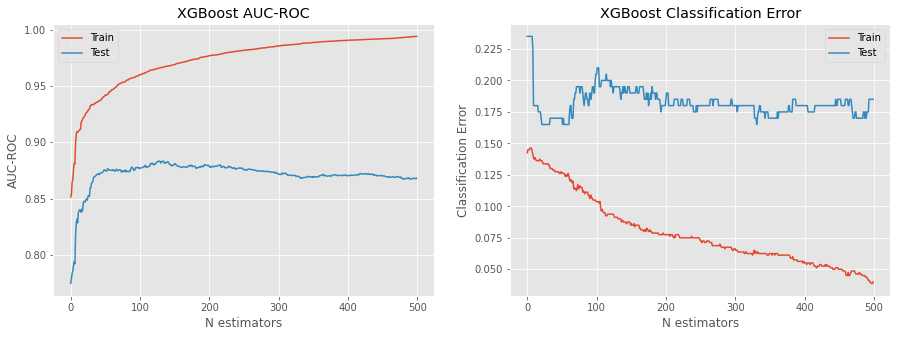

<Figure size 432x288 with 0 Axes>

In [51]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

In [52]:
# create a default XGBoost classifier
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CPU times: user 1.31 s, sys: 54.6 ms, total: 1.36 s
Wall time: 49.1 s


In [53]:
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

Best score: 0.9016449494527787
Best model: {'subsample': 1.0, 'reg_lambda': 1.5, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [54]:
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.86625
Test Accuraccy:  0.82

Confusion Matrix:
[[142  12]
 [ 24  22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       154
           1       0.65      0.48      0.55        46

    accuracy                           0.82       200
   macro avg       0.75      0.70      0.72       200
weighted avg       0.81      0.82      0.81       200



## Leverage GPU

In [55]:
# create a default XGBoost classifier
# model = XGBClassifier(
#     random_state=seed, 
#     eval_metric=["error", "auc"]
# )

model = XGBClassifier(
    tree_method = "gpu_hist", 
    random_state=seed, 
    eval_metric=["error", "auc"]
)

# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model_gpu = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CPU times: user 2.76 s, sys: 914 ms, total: 3.67 s
Wall time: 13min 4s


In [1]:
print(f'Best score: {best_model_gpu.best_score_}')
print(f'Best model: {best_model_gpu.best_params_}')

NameError: ignored

In [57]:
pred_test = best_model_gpu.predict(X_test)
pred_train = best_model_gpu.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.89875
Test Accuraccy:  0.82

Confusion Matrix:
[[138  16]
 [ 20  26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       154
           1       0.62      0.57      0.59        46

    accuracy                           0.82       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.81      0.82      0.82       200



In [58]:
model = XGBClassifier(
    tree_method = "gpu_hist", 
    random_state=seed, 
    eval_metric=["error", "auc"]
)

In [2]:
# store the winning model in a new variable
xgc = best_model_gpu.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = X.columns.to_list()
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

NameError: ignored

In [ ]:
# Create the feature importances plot
fig, ax = plt.subplots(figsize=(20,20))
# plot a decision tree from the booster
xgb.plot_tree(booster=xgc, num_trees=0, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()